In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import math
from sklearn.neighbors import NearestNeighbors

In [362]:
df = pd.read_csv("Dataset/ParkingData_Month_Time_Week.csv")

In [363]:
df.shape

(1048575, 53)

In [364]:
df.head(2)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vio_Time,Latitude,Longitude,count,Hour,Day,Day_Num,Issue Month,Vio_Hour,Time_Num
0,1417714839,DJR2559,NY,PAS,5/12/2017 0:00,46,SUBN,FORD,P,44675,...,10/26/2019 13:34,40.619868,-74.159402,1,13,Friday,4,5,13,2
1,8471209986,XEDS80,NJ,PAS,10/4/2016 0:00,19,DELV,FRUEH,T,13610,...,10/26/2019 9:49,40.812420,-73.960534,1,9,Tuesday,1,10,9,1


In [365]:
data = df[['Latitude','Longitude','count','Day_Num','Issue Month','Time_Num','Street Name']]

In [366]:
data.head(2)

,Latitude,Longitude,count,Day_Num,Issue Month,Time_Num,Street Name
0,40.619868,-74.159402,1,4,5,2,REGIS DRIVE
1,40.812420,-73.960534,1,1,10,1,Broadway


In [367]:
X = data[["Latitude","Longitude"]]

In [416]:
#select sample January,Monday,Morning time
sample= data[(data['Day_Num']==4) & (data['Issue Month']==5) & (data['Time_Num']==2)]
print(sample.head(2))
print(sample.shape)

     Latitude  Longitude  count  Day_Num  Issue Month  Time_Num  Street Name
0   40.619868 -74.159402      1        4            5         2  REGIS DRIVE
17  40.734042 -73.873034      1        4            5         2  Queens Blvd
(5794, 7)


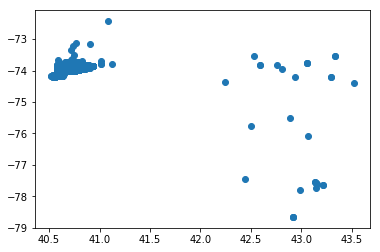

In [417]:
plt.scatter(sample['Latitude'],sample['Longitude'])

In [418]:
sample_x = sample[['Latitude','Longitude']]

In [419]:
# get min pts value -- heuristic method
min_pts = round(math.log(sample.shape[0]))
print(min_pts)

9


In [420]:
# to get value of eps distance using kNN knee method
# selecting value of k = min_pts
neigh = NearestNeighbors(n_neighbors=min_pts)
nbrs = neigh.fit(sample_x)
distances, indices = nbrs.kneighbors(sample_x)

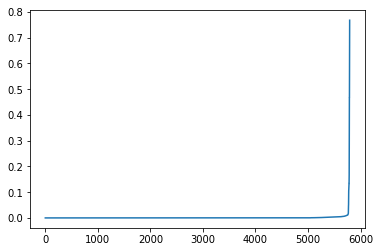

In [421]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
# no visible knee

<h1>DBSCAN</h1>

In [422]:
#build dbscan model for sample_x
m = DBSCAN(eps=0.5, min_samples=min_pts)
m.fit(sample_x)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=9, n_jobs=None, p=None)

In [423]:
#get cluster labels
clusters = m.labels_
print(set(clusters))

{0, 1, 2, -1}


In [424]:
#count number of clusters -1 means outlier
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
print("number of clusters = ",n_clusters_)

number of clusters =  3


In [425]:
#plotting clusters
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

Text(0,0.5,'Longitude')

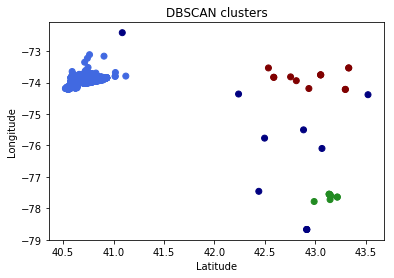

In [438]:
plt.scatter(sample_x.iloc[:,0], sample_x.iloc[:,1], c=vectorizer(clusters))
plt.title("DBSCAN clusters")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

In [427]:
clustered_x = sample_x
clustered_x['cluster']=clusters
clustered_x['street name']=sample['Street Name']
print(clustered_x.head())

      Latitude  Longitude  cluster           street name
0    40.619868 -74.159402        0           REGIS DRIVE
17   40.734042 -73.873034        0           Queens Blvd
194  40.656108 -73.939568        0          Clarkson Ave
363  40.861038 -73.850220        0            Waring Ave
542  40.680225 -73.776946        0  NB BAISLEY BLVD @ 15


<h1> K Nearest Neighbours </h1>

In [428]:
#Applying KNN to DBSCAN clustered data to predict cluster

In [429]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [430]:
x = clustered_x[['Latitude','Longitude']]
y = clustered_x['cluster']

In [431]:
len(clustered_x)

5794

In [432]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [433]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [434]:
#show first 5 model predictions on the test data
knn.predict(x_test)[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

<h1>Performance Metrics</h1>

In [435]:
knn.score(x_test, y_test)

0.998274374460742

In [436]:
from sklearn.model_selection import cross_val_score
import numpy as np
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, x, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.99827586 0.99913793 1.         0.99913644 0.99827139]
cv_scores mean:0.9989643253549781


<h1>Implementation</h1>

In [437]:
# for given test case: Print top 3 streets to stay away from
#for case when not safe
x_coord,y_coord=40.61,-74.15
case_coords= [x_coord,y_coord]
case_cluster = knn.predict(np.array(case_coords).reshape(1,-1))
if(case_cluster[0]!=-1):
    distances,indices = knn.kneighbors(np.array(case_coords).reshape(1,-1))
    #print(distances)
    if(min(distances[0])>1):
        print("Safe to Park")
    else:
        print("Not safe to park!!!")
        print("Also Avoid the following areas:")
        for i in indices[0]:
            print(np.array(clustered_x['street name'])[i])
else:
    print("Safe To Park")


Not safe to park!!!
Also Avoid the following areas:
E 29th St
Wooster St
SB FLATBUSH AVE EXT


In [415]:
# for given test case: Print top 3 streets to stay away from
#for case when safe
x_coord,y_coord=43,-74
case_coords= [x_coord,y_coord]
case_cluster = knn.predict(np.array(case_coords).reshape(1,-1))
if(case_cluster[0]!=-1):
    distances,indices = knn.kneighbors(np.array(case_coords).reshape(1,-1))
    #print(distances)
    if(min(distances[0])>1):
        print("Safe to Park")
    else:
        print("Not safe to park!!!")
        print("Also Avoid the following areas:")
        for i in indices[0]:
            print(np.array(clustered_x['street name'])[i])
else:
    print("Safe To Park")


Safe to Park
